Average chunk size: 123.73 KB
Median chunk size: 123.66 KB


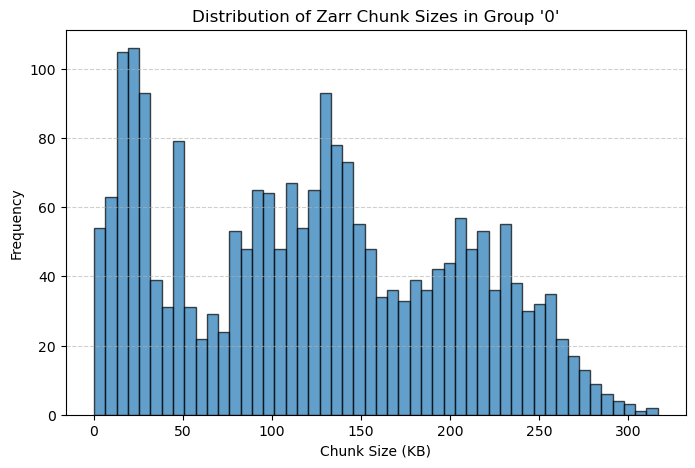

In [19]:
import os
import numpy as np
import zarr
import matplotlib.pyplot as plt

def analyze_zarr_chunks(zarr_store_path: str, group_path: str):
    """
    Analyze and visualize the distribution of chunk sizes in a Zarr store.

    Parameters:
    -----------
    zarr_store_path : str
        Path to the Zarr store (e.g., directory).
    group_path : str
        The group inside the Zarr store to analyze.
    """

    group_full_path = os.path.join(zarr_store_path, group_path)

    if not os.path.exists(group_full_path):
        print(f"Group {group_path} does not exist in {zarr_store_path}")
        return

    chunk_sizes = []

    # Walk through all chunk files in the specified group
    for root, _, files in os.walk(group_full_path):
        for file in files:
            file_path = os.path.join(root, file)
            chunk_sizes.append(os.path.getsize(file_path))

    if not chunk_sizes:
        print("No chunk files found in the specified group.")
        return

    # Convert to numpy array for stats
    chunk_sizes = np.array(chunk_sizes)

    # Compute statistics
    avg_size = np.mean(chunk_sizes) / 1024  # Convert to KB
    median_size = np.median(chunk_sizes) / 1024  # Convert to KB

    print(f"Average chunk size: {avg_size:.2f} KB")
    print(f"Median chunk size: {median_size:.2f} KB")

    # Plot histogram
    plt.figure(figsize=(8, 5))
    plt.hist(chunk_sizes / 1024, bins=50, edgecolor="black", alpha=0.7)  # Convert to KB
    plt.xlabel("Chunk Size (KB)")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of Zarr Chunk Sizes in Group '{group_path}'")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()

# Example Usage
zarr_store_path = r"C:\Users\P70078823\Desktop\MSIConverter\pea_16x16_pixels.zarr"  # Change this to your Zarr directory
group_path = "0"  # Change this to your specific group

analyze_zarr_chunks(zarr_store_path, group_path)


In [20]:
import zarr

z = zarr.open_group(zarr_store_path, mode='r')
group = z[group_path]

# Get chunk size in bytes before compression
chunk_shape = group.chunks  # Chunk dimensions
dtype_size = group.dtype.itemsize  # Size of one element in bytes
num_elements_per_chunk = np.prod(chunk_shape)  # Total elements per chunk
uncompressed_chunk_size = num_elements_per_chunk * dtype_size / (1024 * 1024)  # Convert to MB

print(f"Chunk Shape: {chunk_shape}")
print(f"Uncompressed Chunk Size: {uncompressed_chunk_size:.2f} MB")


Chunk Shape: (10000, 1, 16, 16)
Uncompressed Chunk Size: 19.53 MB


In [24]:
import zarr
import xarray as xr
import dask.array as da
import numpy as np

# Path to your Zarr store
zarr_path = r"C:\Users\P70078823\Desktop\MSIConverter\pea_16x16_pixels.zarr"

# Open the Zarr file with xarray
ds = xr.open_zarr(zarr_path)

ds

<xarray.Dataset> Size: 46GB
Dimensions:  (c: 331701, z: 1, y: 133, x: 131)
Dimensions without coordinates: c, z, y, x
Data variables:
    0        (c, z, y, x) float64 46GB dask.array<chunksize=(10000, 1, 16, 16), meta=np.ndarray>
Attributes:
    imzml:        {'source': 'C:\\Users\\P70078823\\OneDrive\\Desktop\\Taste ...
    multiscales:  [{'axes': ['c', 'z', 'y', 'x'], 'datasets': [{'path': '0'}]...

In [21]:
import zarr
import numpy as np
import dask.array as da
import plotly.express as px
import pandas as pd

# Open the Zarr store
root = zarr.open(zarr_store_path, mode='r')

# Access the main intensity dataset
zarr_array = root["0"]  # Adjust if needed

# Convert to Dask array for lazy evaluation
dask_array = da.from_zarr(zarr_array)

def count_nonzero_per_chunk(dask_array) -> np.ndarray:
    """
    Counts the number of nonzero values in each chunk of a Dask-backed Zarr array.

    Parameters:
    -----------
    dask_array : dask.array.Array
        The Dask array wrapping the Zarr dataset.

    Returns:
    --------
    np.ndarray
        An array with the count of nonzero values per chunk.
    """
    # Compute nonzero counts per chunk
    nonzero_counts = da.sum(dask_array != 0, axis=(1, 2, 3))  # Adjust axes for your shape
    return nonzero_counts.compute()  # Compute the result

# Get the number of nonzero entries per chunk
nonzero_counts = count_nonzero_per_chunk(dask_array)

# Convert to a DataFrame for easy plotting
df = pd.DataFrame({"Non-Zero Values per Chunk": nonzero_counts})

# Plot histogram using Plotly
fig = px.histogram(df, x="Non-Zero Values per Chunk", nbins=500, title="Distribution of Non-Zero Entries Per Chunk")
fig.show()


KeyboardInterrupt: 

In [ ]:
import zarr
import numpy as np
import dask.array as da
import plotly.express as px
import pandas as pd


# Open the Zarr store
root = zarr.open(zarr_store_path, mode='r')

# Access the main intensity dataset
zarr_array = root["0"]  # Adjust if needed

# Convert to Dask array for lazy evaluation
dask_array = da.from_zarr(zarr_array)

def get_nonzero_counts(dask_array) -> np.ndarray:
    """
    Computes the number of non-zero values in each chunk.

    Parameters:
    -----------
    dask_array : dask.array.Array
        The Dask array wrapping the Zarr dataset.

    Returns:
    --------
    np.ndarray
        The count of nonzero values per chunk.
    """
    return da.sum(dask_array != 0, axis=(1, 2, 3)).compute()

# Get non-zero counts per chunk
nonzero_counts = get_nonzero_counts(dask_array)

# Find chunks with fewer than 50 non-zero entries
low_density_chunk_indices = np.where(nonzero_counts < 50)[0]

# Function to extract nonzero intensity values from selected chunks
def extract_nonzero_intensities(dask_array, low_density_chunk_indices) -> np.ndarray:
    """
    Extracts all non-zero intensity values from chunks that have fewer than 50 non-zero entries.

    Parameters:
    -----------
    dask_array : dask.array.Array
        The Dask array wrapping the Zarr dataset.
    low_density_chunk_indices : np.ndarray
        Indices of chunks that have fewer than 50 non-zero values.

    Returns:
    --------
    np.ndarray
        Array of all non-zero intensity values from these chunks.
    """
    nonzero_values = []
    
    for idx in low_density_chunk_indices:
        chunk_data = dask_array[idx].compute().flatten()  # Load chunk into memory
        nonzero_values.extend(chunk_data[chunk_data != 0])  # Collect non-zero values
    
    return np.array(nonzero_values)

# Extract nonzero intensity values from low-density chunks
nonzero_intensities = extract_nonzero_intensities(dask_array, low_density_chunk_indices)

# Convert to DataFrame for easy plotting
df = pd.DataFrame({"Non-Zero Intensities": nonzero_intensities})

# Plot histogram of non-zero intensities
fig = px.histogram(df, x="Non-Zero Intensities", nbins=100, title="Distribution of Non-Zero Intensities in Low-Density Chunks")
fig.show()


In [22]:
import zarr
import numpy as np
import dask.array as da


# Open the Zarr store
root = zarr.open(zarr_store_path, mode='r')

# Access the main intensity dataset
zarr_array = root["0"]  # Adjust if needed

# Convert to Dask array for lazy loading
dask_array = da.from_zarr(zarr_array)

def count_empty_chunks(dask_array, threshold: float = 0.00000) -> int:
    """
    Counts the number of empty chunks in a Dask-backed Zarr array.

    Parameters:
    -----------
    dask_array : dask.array.Array
        The Dask array wrapping the Zarr dataset.
    threshold : float, optional
        The value below which a chunk is considered empty (default: 0.0).

    Returns:
    --------
    int
        The number of empty chunks.
    """
    empty_mask = da.all(dask_array <= threshold, axis=(0, 1, 2, 3))  # Adjust axes for your shape
    empty_chunk_count = empty_mask.compute().sum()
    return empty_chunk_count

# Count empty chunks
num_empty_chunks = count_empty_chunks(dask_array)

# Print result
print(f"Number of empty chunks: {num_empty_chunks}")


Number of empty chunks: 0


In [23]:
zarr_group = zarr.open_group(zarr_path, mode='r')
print(zarr_group.tree())



/
 ├── 0 (331701, 1, 133, 131) float64
 └── labels
     └── common_mass_axis
         └── 0 (331701,) float64


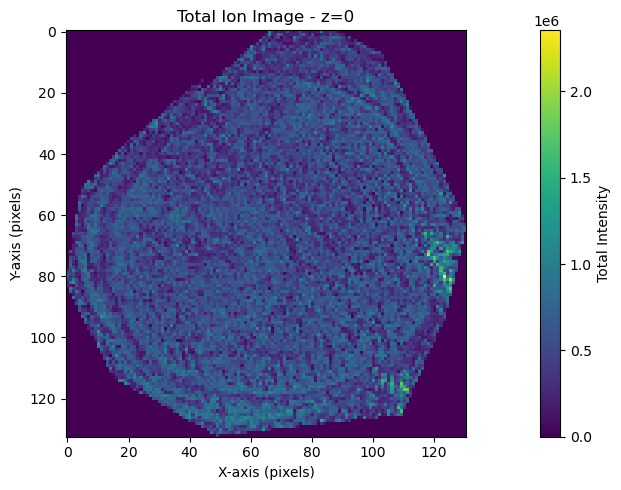

In [31]:
import dask.array as da
import zarr
import matplotlib.pyplot as plt

# Define the path to your Zarr store
zarr_path = r"pealz4NOshuffle.zarr"

# Open the Zarr file directly with Zarr
zarr_group = zarr.open_group(zarr_path, mode='r')

# Access the intensity dataset (shape: c, z, y, x)
intensities = da.from_zarr(zarr_group["0"])

# Compute the Total Ion Image (TIC) by summing along the m/z axis (axis=0)
total_ion_image = intensities.sum(axis=0).compute()  # Shape: (z, y, x)

# Check the number of z-slices
num_z_slices = total_ion_image.shape[0]

# Plot each z-plane separately
fig, axes = plt.subplots(1, min(num_z_slices, 5), figsize=(15, 5))  # Limit to 5 subplots max
if num_z_slices == 1:
    axes = [axes]  # Ensure axes is iterable if there's only one slice

for i in range(min(num_z_slices, 5)):  # Plot up to 5 slices
    ax = axes[i]
    img = ax.imshow(total_ion_image[i], cmap='viridis')
    fig.colorbar(img, ax=ax, label='Total Intensity')
    ax.set_title(f'Total Ion Image - z={i}')
    ax.set_xlabel('X-axis (pixels)')
    ax.set_ylabel('Y-axis (pixels)')

plt.tight_layout()
plt.show()
